In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as p
from itertools import combinations
import json

## I: Implementación

### Calculo de error cuadrático

In [27]:
def error_rate(w, X, Y):
    N = X.shape[0]
    E = 0
    for i in range(N):
        E += (np.dot(X[i],w) - Y[i])**2
    return E[0]/N

### Algoritmo de descenso de gradiente

In [28]:
# Algoritmo de descenso de gradiente
def gradient_descent(X, Y, weights, learning_rate):

    dldw = np.zeros((len(weights), 1))
    N = X.shape[0] # número de filas de la matriz X

    # Calculo de la derivada parcial de loss con respecto a cada peso
    for i in range(N):
        dldw += np.transpose([X[i]]) * ((Y[i] - np.dot(X[i], weights))[0])

    weights = weights + learning_rate * dldw
    
    return weights

### Generacion de funcion linear aleatoria de tamaño determinado

In [29]:
# Inicialización de Parámetros
def generate_linear_function(size):
    random_seed = 1
    weight_range = 100
    x_range = 100 
    number_seeds = 1000
    
    weights = np.random.choice(np.concatenate((np.arange(-weight_range, 0), np.arange(1, weight_range+1))), size=(size, 1)) #pesos a estimar
    X0 = np.ones((number_seeds, 1)) #parametro X0 equivalente a 1 en cada vector X add 
    X1toN = np.random.randint(1, x_range+1, size=(number_seeds, size-1))  
    X = np.concatenate((X1toN, X0), axis=1)# X = conjunto de variables independientes

    #Y = X1toN*w # + w0 que no consideramos por no ser significativa
    Y = np.dot(X,weights) 

    return weights, X, Y

### Funcion de aprendizaje

In [30]:
def learner(X, Y, size, learning_rate, max_iter, epsilon, w=[]):
    if len(w) == 0: w = np.ones((size,1)) #pesos iniciales
    error = []

    #Iteración del algoritmo 
    for i in range(max_iter):
        w = gradient_descent(X, Y, w, learning_rate)
        err = error_rate(w, X, Y)
        error.append(err)
        if err < epsilon:
            break
    return w, error

### Prueba de la funcion de aprendizaje con una funcion linear aleatoria

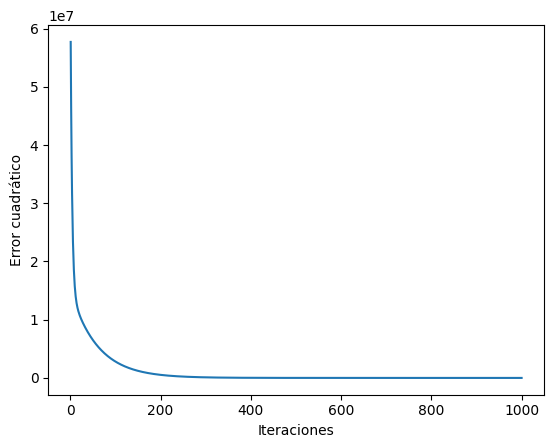

pesos reales: [[-55  87 -76 -28 -69 -57]]
pesos estimados: [[-55.20641501  86.75577666 -76.19729835 -28.19550286 -69.21579619
    0.42607444]]
porcentaje de error: [[  0.37530002]
 [  0.28071648]
 [  0.2596031 ]
 [  0.69822452]
 [  0.3127481 ]
 [100.74749902]]


In [42]:

size = 6
function_weights, X, Y = generate_linear_function(size) 
w, error = learner(X, Y, size, 0.00000001, 1000, 0.5)

p.plot([i+1 for i in range(len(error))], error)
p.xlabel("Iteraciones")
p.ylabel("Error cuadrático")
p.show()

print(f"pesos reales: {np.transpose(function_weights)}")
print(f"pesos estimados: {np.transpose(w)}")

def porcentage_error(real, estimated):
    return np.abs(((estimated * 100) / real) - 100)

print(f"porcentaje de error: {porcentage_error(function_weights, w)}")

## II: Preprocesamiento de datos

In [32]:
# loading data
old_df = pd.read_csv('CarDekho.csv')

### Manejo de valores faltantes

In [33]:

# Ver los valores nulos
df_nulos = old_df.isnull().sum().reset_index()
df_nulos.columns = ['variable', '# nulos']
df_nulos = df_nulos[df_nulos['# nulos'] > 0]
df_nulos

,variable,# nulos
11,Engine,80
12,Max Power,80
13,Max Torque,80
14,Drivetrain,136
15,Length,64
16,Width,64
17,Height,64
18,Seating Capacity,64
19,Fuel Tank Capacity,113


De las tablas en el archivo .csv, aquellas con valores nulos son:
* Engine
* Max Power
* Max Torque
* Drivetrain
* Length
* Width
* Height
* Seaing Capacity
* Fuel Tank Capacity

En este caso, el manejo de datos faltantes se realizará de la siguiente manera:
* **Valores numéricos:**  Se reemplazan por la mediana del atributo.
* **Valores no numéricos:** Se reemplazan por el valor más común del atributo.

In [34]:
df = old_df

# Manejo de datos faltantes para valores numéricos
mean_length = df.loc[:, 'Length'].mean()
mean_width = df.loc[:, 'Width'].mean()
mean_height = df.loc[:, 'Height'].mean()
mean_seats = df.loc[:, 'Seating Capacity'].mean()
mean_tank = df.loc[:, 'Fuel Tank Capacity'].mean()

#conversion de datos de la columna Engine a numéricos
df['Engine'] = pd.to_numeric(df.loc[:,'Engine'].str.strip(" cc"), errors='coerce')
mean_engine = df.loc[:, 'Engine'].mean()

# Manejo de datos faltantes para valores categóricos
common_drive = df.loc[:, 'Drivetrain'].value_counts().index[0]
common_power = df.loc[:, 'Max Power'].value_counts().index[0]
common_torque = df.loc[:, 'Max Torque'].value_counts().index[0]

# Reemplazo de valores nulos
df.loc[:, 'Length'] = df.loc[:, 'Length'].fillna(mean_length)
df.loc[:, 'Width'] = df.loc[:, 'Width'].fillna(mean_width)
df.loc[:, 'Height'] = df.loc[:, 'Height'].fillna(mean_height)
df.loc[:, 'Seating Capacity'] = df.loc[:, 'Seating Capacity'].fillna(mean_seats)
df.loc[:, 'Fuel Tank Capacity'] = df.loc[:, 'Fuel Tank Capacity'].fillna(mean_tank)
df.loc[:, 'Drivetrain'] = df.loc[:, 'Drivetrain'].fillna(common_drive)
df.loc[:, 'Engine'] = df.loc[:, 'Engine'].fillna(mean_engine)
df.loc[:, 'Max Power'] = df.loc[:, 'Max Power'].fillna(common_power)
df.loc[:, 'Max Torque'] = df.loc[:, 'Max Torque'].fillna(common_torque)

### Normalización de los datos

<Axes: >

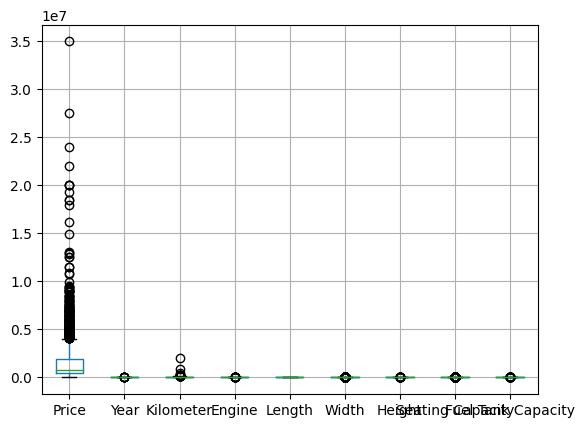

In [35]:
df.boxplot()

Del boxplot, se observa que las columnas *Price* y *Kilometer* tienen valores mucho mayores que las demás variables. Por ende, se normalizan todas las columnas numéricas para que sus valores estén entre 0 y 1 y den datos más concisos.

<Axes: >

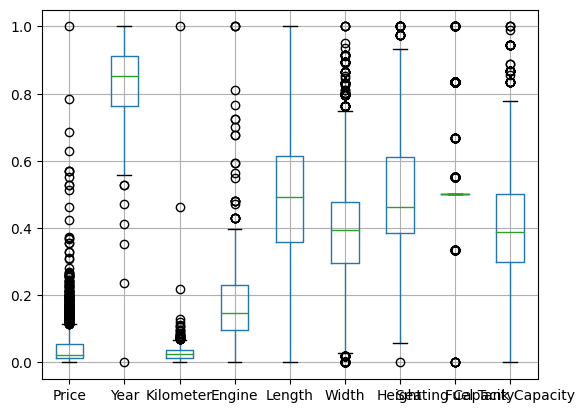

In [36]:
def normalize_column(column):
    return (column - column.min()) / (column.max() - column.min())

# Normalización de datos
df.loc[:, 'Price'] = normalize_column(df.loc[:, 'Price'])
df.loc[:, 'Year'] = normalize_column(df.loc[:, 'Year'])
df.loc[:, 'Kilometer'] = normalize_column(df.loc[:, 'Kilometer'])
df.loc[:, 'Engine'] = normalize_column(df.loc[:, 'Engine'])
df.loc[:, 'Length'] = normalize_column(df.loc[:, 'Length'])
df.loc[:, 'Width'] = normalize_column(df.loc[:, 'Width'])
df.loc[:, 'Height'] = normalize_column(df.loc[:, 'Height'])
df.loc[:, 'Seating Capacity'] = normalize_column(df.loc[:, 'Seating Capacity'])
df.loc[:, 'Fuel Tank Capacity'] = normalize_column(df.loc[:, 'Fuel Tank Capacity'])

df.boxplot()

Las columnas _Max Power_ y _Max Torque_ serán eliminadas debido a la dificultad de estandarizar estos datos como valor numérico

In [37]:
df = df.drop('Max Power', axis=1)
df = df.drop('Max Torque', axis=1)

Tenemos entonces 17 atributos con los que trabajar.

In [38]:
attributes = list(df.loc[:, df.columns != "Price"].columns)
attributes

['Make',
 'Model',
 'Year',
 'Kilometer',
 'Fuel Type',
 'Transmission',
 'Location',
 'Color',
 'Owner',
 'Seller Type',
 'Engine',
 'Drivetrain',
 'Length',
 'Width',
 'Height',
 'Seating Capacity',
 'Fuel Tank Capacity']



Finalmente se utiliza la función get_dummies de la librería Panda para crear nuevas $n$ columnas para cada uno de los atributos categóricos de $n$ categorías que tenemos

También creamos una lista ```indexes```, que continene en cada índice $i$, los $j$ índices de las columnas dummy creadas en base a la $i$ columna de la data original, que será utilizada más adelante

In [39]:

a = [ len(pd.get_dummies(df[[col]]).columns) for col in df.loc[:, df.columns != "Price"].columns]
indexes = [list(range(a[0]))] + [list(range(sum(a[0:i]), sum(a[0:i]) +  a[i])) for i in range(1,len(a))]

df = pd.get_dummies(df, dtype=int)

Para mantener los valores pre-procesados guardados, creamos un nuevo csv que es con el que estaremos trabajando de aquí en adelante.

In [40]:
df.to_csv('clean_data.csv', index=False)
df = pd.read_csv('clean_data.csv')

KeyboardInterrupt: 

## III: Entrenamiento del modelo

### Seleccion de columnas

La selección de columnas a utilizar en los vectores de ejemplo para el el entrenamiento del modelo será mediante un hiperparámetro que definirá las columnas a utilizar. Para esto calcularemos las combinaciones posibles de columnas, tal que no se permuten y se mantenga el orden relativo entre ellas. Luego generamos un modelo para cada una, y escogemos la combinación con el menor error cuadrático estimado

Por cuestiones de tiempo, y puesto que es muy probable que con significativamente menos atributos el modelo esté subajustado, solo se considerarán las combinaciones de tamaño 8 y 9. Las combinaciones son guardadas en un archivo para eliminar el tiempo de computación de estas durante la selección del modelo

In [ ]:
for c_size in range(8,9):
    cs = []
    for c in (list(c) for c in combinations(range(len(attributes)), c_size)):
        cs.append(c)
    f = open(f"c{str(c_size)}.txt", "w")
    f.write(str(cs))
    f.close()

Definimos ahora las funciones para validación cruzada y selección de modelo. Se toman como hiperparámetros la cantidad $k$ de subconjutos de partición para la validación cruzada, el archivo de combinaciones a leer y dos indices ($a$, $b$) de la lista de combinaciones, para probar combinaciones solo en ese intervalo

In [ ]:

def model_selection(X, Y, k, learning_rate, max_iter, epsilon, txt, a, b):
    #dividimos los ejemplos en dos partes, los conjuntos de entrenatmiento y el de prueba
    np.random.seed()
    s1 = np.random.choice(range(X.shape[0]), X.shape[0]*3//4, replace=False)
    s2 = list(set(range(X.shape[0])) - set(s1))
    training_X = X[s1, :]
    training_Y = Y[s1, :]
    test_X = X[s2, :]
    test_Y = Y[s2, :]

    combinations = []
    errs = []

    #Entrenamos con validación cruzada el modelo con un subconjunto de combinaciones dado
    f = open(txt, "r")
    column_combinations = json.loads(f.readline())[a:b]
    f.close()
    for c in column_combinations:
        combinations.append(c)
        #Utilizamos la lista indexes para asegurarnos que, al escoger una columna i de la data original, 
        #la combinación incluya los j índices de las columnas dummy correspondientes
        Xc = training_X[:,sum([indexes[i] for i in c], [])] 

        errs.append(cross_validation(Xc, training_Y, k, learning_rate, max_iter, epsilon))

    i = errs.index(min(errs))
    c = combinations[i]
    ids = sum([indexes[i] for i in c], [])
    Xc = training_X[:,ids] 

    w = learner(Xc, Y, len(ids), learning_rate, max_iter, epsilon)[0]

    test_Xc = test_X[:,ids]

    return w, c, error_rate(w, test_Xc, test_Y)

def cross_validation(X, Y, k,learning_rate, max_iter, epsilon):
    N, w_size = X.shape
    errs = 0
    for i in range(k):
        vdi = range((i-1)*N//k, i*N//k)
        tsi = list(set(range(N)) - set(vdi))
        validation_X = X[vdi, : ]
        validation_Y = Y[vdi, : ]
        training_X = X[tsi, :]
        training_Y = Y[tsi, :]

        w = learner(training_X, training_Y, w_size, learning_rate, max_iter, epsilon)[0]

        errs += error_rate(w, validation_X, validation_Y)
    
    return errs/k
        



Establecemos la matriz vectorial X de los ejemplos para el entrenamiento, así como el vector Y correspondiente a cada vector de atributos

In [ ]:
X = df.loc[:, df. columns != "Price"].to_numpy()
Y =  df[["Price"]].to_numpy()

Iteramos ahora sobre las combinaciones de parámetros para seleccionar la combinación con menor error cuadrático estimado.

Se probaron los intervalos [0,1079] U [2500,3120] en c8.txt y [0,2249] U [19540,19640] en c9.txt, con parámetros de aprendizaje que minimizaran el tiempo de corrida (numero de iteraciones y tasa de aprendizaje), para probar la mayor cantidad posible de combinaciones.

In [ ]:
model_selection(X, Y, 5, 0.000002, 500, 0.15, "c9.txt", 3453,3454)

FileNotFoundError: [Errno 2] No such file or directory: 'c9.txt'

 Luego, de las mejores combinaciones encontradas, guardadas en el archivo best.txt, se probó nuevamente utilizando parámetros de aprendizaje mas estrictos. De ahi escogemos la combinación final de columnas a utilizar

In [ ]:
w, c, e = model_selection(X, Y, 5, 0.0000005, 2000, 0.15,  "best.txt", None,None)
([attributes[i] for i in c], e)

(['Make',
  'Model',
  'Year',
  'Kilometer',
  'Fuel Type',
  'Transmission',
  'Drivetrain',
  'Width',
  'Seating Capacity'],
 0.12446431685138888)

Entrenamos ahora al modelo

In [ ]:
columns = [attributes.index(i) for i in ['Make',
  'Model',
  'Year',
  'Kilometer',
  'Fuel Type',
  'Transmission',
  'Drivetrain',
  'Width',
  'Seating Capacity']]

ids = sum([indexes[i] for i in columns], [])

Xc = X[:,ids] 
w, err = learner(Xc, Y, len(ids), 0.0000013, 160000, 0.005)

Guardamos los resultados en ```w.txt```

In [ ]:
wtxt = open("w.txt", "w")
wtxt.write(str(np.concatenate(w).tolist()))
wtxt.close()